In [35]:
%matplotlib inline


In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from matplotlib.lines import Line2D

import matplotlib.ticker as tck


In [147]:
run.keys()

Index(['_step', '_runtime', 'train/loss', 'train/learning_rate', 'train/epoch',
       '_timestamp', 'train/global_step', 'eval/rouge1', 'eval/rouge2',
       'eval/rougeL', 'eval/loss', 'eval/rougeLsum', 'eval/steps_per_second',
       'eval/samples_per_second', 'eval/runtime', 'eval/gen_len',
       'train/train_loss', 'train/train_steps_per_second',
       'train/train_samples_per_second', 'train/train_runtime',
       'train/total_flos'],
      dtype='object')

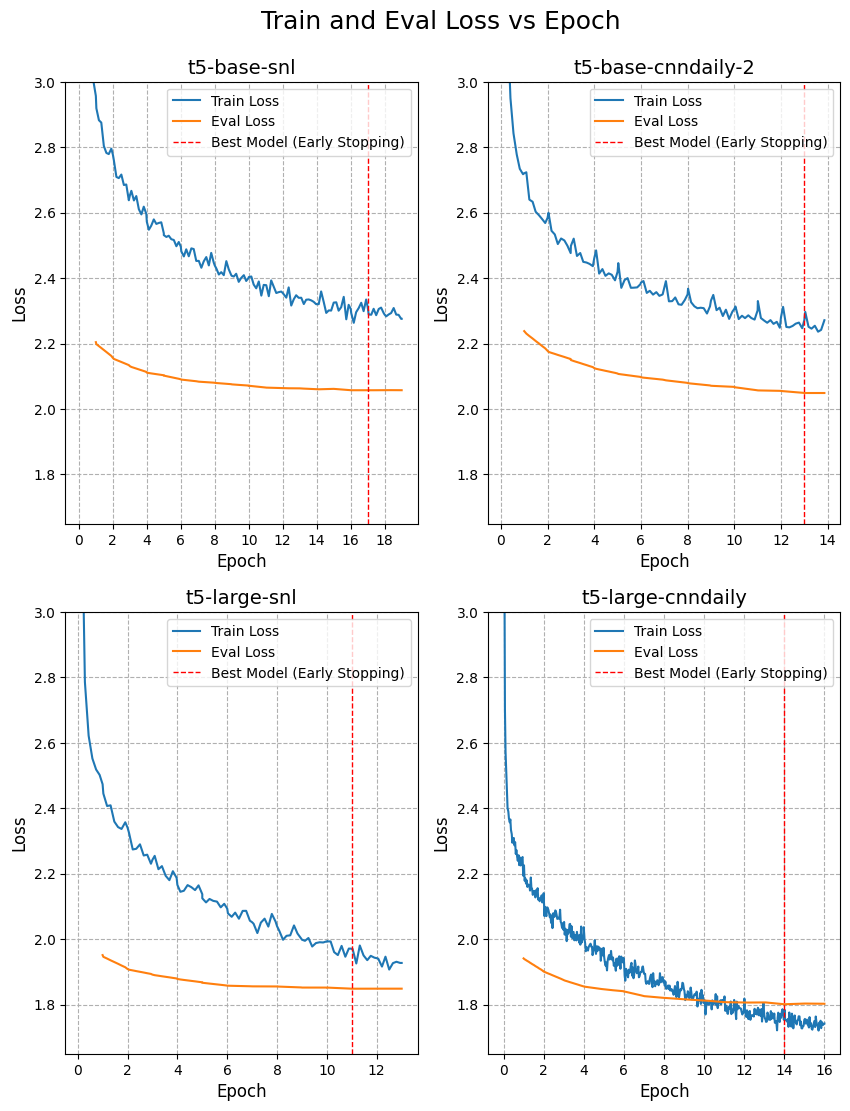

In [171]:
runs = [
    {"model_name": "t5-base-snl", "wandb_url": "/navjordj/huggingface/runs/70ow8xqt"},
    {"model_name": "t5-base-cnndaily-2", "wandb_url": "/navjordj/huggingface/runs/6b3n44zi"},
    {"model_name": "t5-large-snl", "wandb_url": "/navjordj/huggingface/runs/zoy0w9hk"},
    {"model_name": "t5-large-cnndaily", "wandb_url": "/navjordj/huggingface/runs/zrx32j09"},
]

api = wandb.Api()

fig, axes = plt.subplots(2, 2, figsize=(10, 12))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12



plt.style.use('default')

for i, run_info in enumerate(runs):
    run = api.run(run_info["wandb_url"]).history()
    run = run.drop(run.tail(1).index)



    run["train/loss"] = run["train/loss"].interpolate(method="linear")
    run["eval/loss"] = run["eval/loss"].interpolate(method="linear")

    ax = axes[i // 2, i % 2]

    ax.xaxis.set_major_locator(tck.MultipleLocator(2))


    train_loss_line = ax.plot(run["train/epoch"], run["train/loss"], label="Train Loss", linewidth=1.5)
    eval_loss_line = ax.plot(run["train/epoch"], run["eval/loss"], label="Eval Loss", linewidth=1.5)

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_title(f"{run_info['model_name']}", fontsize=14)

    ax.set_ylim(1.65, 3)

    ax.grid(True, linestyle="--", alpha=1)

    # Add a vertical line at the epoch corresponding to the minimum value of eval/loss
    min_eval_loss_index = run["eval/loss"].idxmin()
    min_eval_loss_epoch = run.loc[min_eval_loss_index, "train/epoch"]
    best_model_line = ax.axvline(min_eval_loss_epoch, color="red", linestyle="--", linewidth=1, alpha=1)

    custom_lines = [Line2D([0], [0], color=train_loss_line[0].get_color(), lw=1.5),
                    Line2D([0], [0], color=eval_loss_line[0].get_color(), lw=1.5),
                    Line2D([0], [0], color='red', linestyle='--', lw=1)]

    ax.legend(custom_lines, ['Train Loss', 'Eval Loss', 'Best Model (Early Stopping)'], loc='upper right', fontsize=10)

# Add a single title for the entire figure
plt.suptitle("Train and Eval Loss vs Epoch", fontsize=18)
plt.subplots_adjust(top=0.92)
#plt.tight_layout()
plt.savefig("train_losses.png")
plt.show()


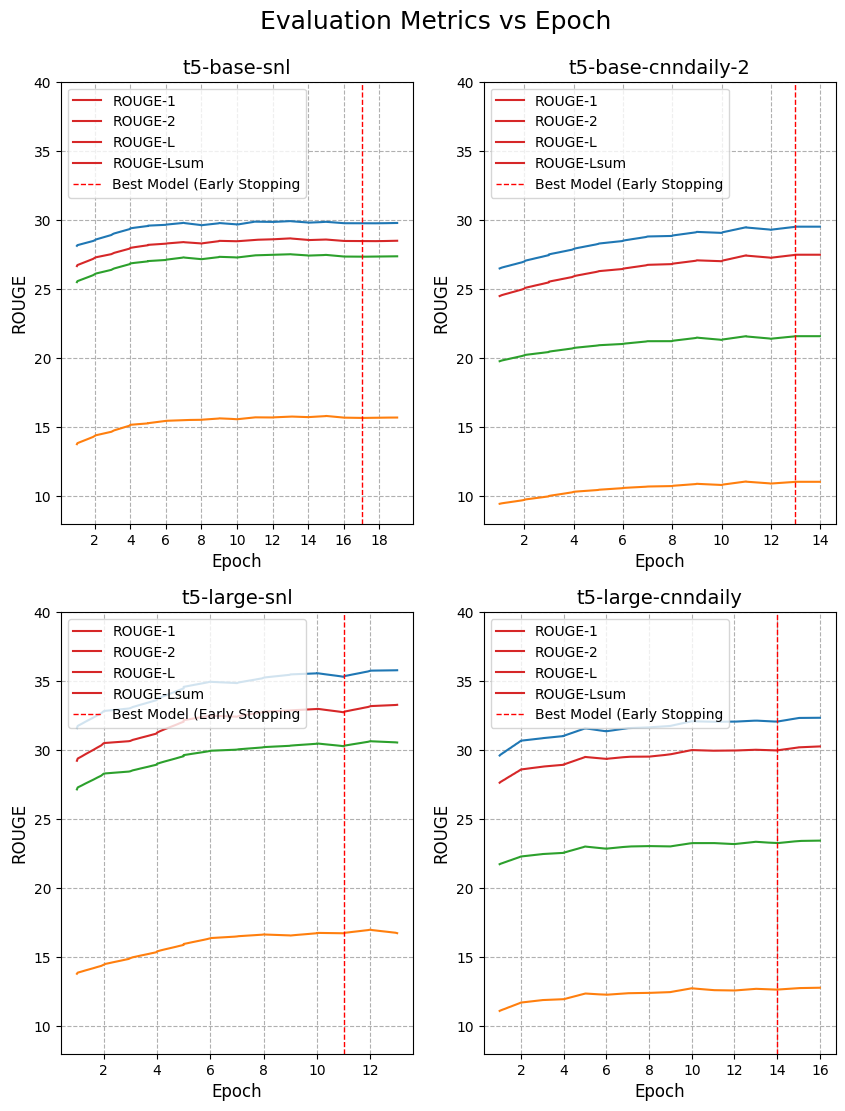

In [206]:
runs = [    {"model_name": "t5-base-snl", "wandb_url": "/navjordj/huggingface/runs/70ow8xqt"},    {"model_name": "t5-base-cnndaily-2", "wandb_url": "/navjordj/huggingface/runs/6b3n44zi"},    {"model_name": "t5-large-snl", "wandb_url": "/navjordj/huggingface/runs/zoy0w9hk"},    {"model_name": "t5-large-cnndaily", "wandb_url": "/navjordj/huggingface/runs/zrx32j09"},]

api = wandb.Api()

fig, axes = plt.subplots(2, 2, figsize=(10, 12))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.style.use('default')

for i, run_info in enumerate(runs):
    run = api.run(run_info["wandb_url"]).history()

    last_epoch = run["train/epoch"].iloc[-1]

    
    # Noe som var merkelig med siste verdi på ROUGE-scorene her. på wandb.ai er det riktig 🤷‍♂️
    if run_info["model_name"] == "t5-base-snl":
        for metric in ['eval/rouge1', 'eval/rouge2', 'eval/rougeL', 'eval/rougeLsum']:
            last_non_nan_value = run[metric].dropna().iloc[-2]
            run.loc[run["train/epoch"] == last_epoch, metric] = last_non_nan_value



    for metric in ['eval/rouge1', 'eval/rouge2', 'eval/rougeL', 'eval/rougeLsum']:
        run[metric] = run[metric].interpolate(method="linear")

    ax = axes[i // 2, i % 2]

    ax.xaxis.set_major_locator(tck.MultipleLocator(2))

    for metric in ['eval/rouge1', 'eval/rouge2', 'eval/rougeL', 'eval/rougeLsum']:
        metric_line = ax.plot(run["train/epoch"], run[metric], label=metric, linewidth=1.5)

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("ROUGE", fontsize=12)
    ax.set_title(f"{run_info['model_name']}", fontsize=14)

    ax.set_ylim(8, 40)


    ax.grid(True, linestyle="--", alpha=1)

    # Add a vertical line at the epoch corresponding to the maximum value of eval/rougeL
    min_eval_loss_index = run["eval/loss"].idxmin()
    min_eval_loss_epoch = run.loc[min_eval_loss_index, "train/epoch"]
    best_model_line = ax.axvline(min_eval_loss_epoch, color="red", linestyle="--", linewidth=1, alpha=1)

    custom_lines = []
    for metric in ['eval/rouge1', 'eval/rouge2', 'eval/rougeL', 'eval/rougeLsum']:
        line = Line2D([0], [0], color=metric_line[0].get_color(), lw=1.5)
        custom_lines.append(line)

    custom_lines.append(Line2D([0], [0], color='red', linestyle='--', lw=1))
    ax.legend(custom_lines, ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum', 'Best Model (Early Stopping'], loc='upper left', fontsize=10)

#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines[:4], labels[:4], loc='upper right', ncol=1, fontsize=14)


# Add a single title for the entire figure
plt.suptitle("ROUGE Metrics vs Epoch", fontsize=18)
plt.subplots_adjust(top=0.92)
#plt.tight_layout()
plt.savefig("rouge_eval_metrics.png")
plt.show()
